In [1]:
from skimage import io as skio

In [16]:
from scipy.optimize import least_squares



In [5]:
import scipy.io
from glob import glob
from scipy import interpolate
from scipy.interpolate import interp2d
from skimage.draw import polygon
import numpy as np

import skimage as sk
import skimage.io as skio



from PIL import Image as im



import math


from tqdm import tqdm

import pickle



import matplotlib.pyplot as plt



### methods (from other files)

In [64]:
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)



In [80]:
def greyify(img):
    means = np.mean(img, axis = 2)
    means.reshape((224, 224, 1))
    return np.stack([means]*3, axis = 2)

In [50]:
simplices=[
        [12, 16, 14],
    [12, 11, 16],
    [11,  9, 16],
    [16,  9, 15],
    [11,  1,  9],
    [ 1,  5,  9],
    [ 9,  5, 15],
    [ 1, 11,  8],
    [ 5,  1,  8],
   
        [ 4,  5,  8],
    [ 5,  4, 15],
    [ 7,  4,  8],
     [11,  2,  8],
    [ 2,  7,  8],
    [ 7,  2, 10],
    [10, 12, 14],


        [ 6, 14, 13],
    [15,  4, 13],
    [ 3,  6, 13],
    [ 4,  3, 13],
    [ 6, 10, 14],
    [ 7,  3,  4],
    [ 0, 10,  6],
    [ 0,  7, 10],
    [ 3,  0,  6],
    [ 7,  0,  3],
    
            [ 2, 11, 12],
    [10,  2, 12],

]

In [45]:
def add_corners_2(ptset):
    corners = np.array([[0, 0, 223, 223], [0, 223, 0, 223]])
    return np.hstack([ptset, corners])

def add_corners_3(ptset):
    corners = np.array([[0, 0, 223, 223], [0, 223, 0, 223], [0, 0, 0, 0]])
    return np.hstack([ptset, corners])   

In [15]:
def angle_estimation_loss(arr, orig, target):
    
    # arr: alpha, beta, gamma, scale
    
    tmx, T = reconstruct_tmx(arr)
    rotated_2d = (tmx @ orig)[:2]
    
    translated = rotated_2d + T
    errors = (translated - target) ** 2
    errors = np.mean(errors, axis = 0)
    
    return errors
    
def reconstruct_tmx(arr):
    alpha, beta, gamma, scale, tx, ty = arr
    ca, cb, cg = math.cos(alpha), math.cos(beta), math.cos(gamma)
    sa, sb, sg = math.sin(alpha), math.sin(beta), math.sin(gamma)
    rotation = [[ca * cb, (ca*sb*sg) - (sa*cg), (ca*sb*cg) + (sa*sg)],
                [sa*cb, (sa*sb*sg) + (ca*cg), (sa*sb*cg) - (ca*sg)],
                [- sb, cb * sg, cb * cg]]
    
    rmx = np.array(rotation)
    rmx = rmx * scale
    
    T = np.array([[tx],[ty]])
    
    return rmx, T

In [42]:
def calculate_one_triangle(simplex, pts_1, pts_2, src_img, dest_img):
    
    # get the triangle corners
    orig_points = pts_1[simplex]
    new_points = pts_2[simplex]
    
    # get the polygon index for source and dest
    old_poly = polygon(orig_points[:,1], orig_points[:,0])
    newpoly = polygon(new_points[:,1], new_points[:,0])
    
    
    
    # get the pixel values for the old image
    r_old = src_img[:,:,0][old_poly]
    g_old = src_img[:,:,1][old_poly]
    b_old = src_img[:,:,2][old_poly]
    
    # get the inverse warp matrix
    tmx = computeAffine(simplex, pts_1, pts_2)
    tmx_i = np.linalg.inv(tmx)
    
    # do the inverse warp
    dest_pixels_matrix = np.vstack((newpoly[1], newpoly[0], np.ones(len(newpoly[0]))))
    inverse_warp = (tmx_i @ dest_pixels_matrix)[:2]
    # interpolate
    try:
        r_new = interpolate.griddata((old_poly), r_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        r_new = np.zeros(len(newpoly[0]))
    try:
        g_new = interpolate.griddata((old_poly), g_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        g_new = np.zeros(len(newpoly[0]))
    try:
        b_new = interpolate.griddata((old_poly), b_old, (inverse_warp[1], inverse_warp[0]), method='nearest')
    except:
        b_new = np.zeros(len(newpoly[0]))
    
    triangle = np.vstack((r_new, g_new,b_new)).T
    triangle = np.clip(triangle, 0, 1)
    
    #apply pixels to dest image
    dest_img[newpoly[0],newpoly[1]] = triangle


def computeAffine(simplex, pts_1, pts_2):
    orig_points = pts_1[simplex]

    new_points = pts_2[simplex]

    b = new_points
    A = np.hstack([orig_points, np.ones(3).reshape((3,1))])

    x = np.linalg.solve(A, b)

    tmx = np.vstack([x.T, [0,0,1]])
    return tmx

"""
this is the same code as the previous section, just with some names changed
"""

def morph(im1, im2, im1_pts, im2_pts, simplices, warp_frac, dissolve_frac):
    
    assert im1.shape == im2.shape
    assert len(im1_pts) == len(im2_pts)

    target_points = (im1_pts * warp_frac) + (im2_pts * (1 - warp_frac))
    
    im1_warped = np.zeros(im1.shape, dtype = float)
    im2_warped = np.zeros(im1.shape, dtype = float)
    
    for idx, simplex in enumerate(simplices):
        calculate_one_triangle(simplex, im1_pts, target_points, im1, im1_warped)
        calculate_one_triangle(simplex, im2_pts, target_points, im2, im2_warped)
        
    combined = im1_warped*dissolve_frac + im2_warped*(1-dissolve_frac)
    return combined

### steps

In [82]:
not_my_dog = skio.imread('not_my_dog.jpg').astype(float)/255

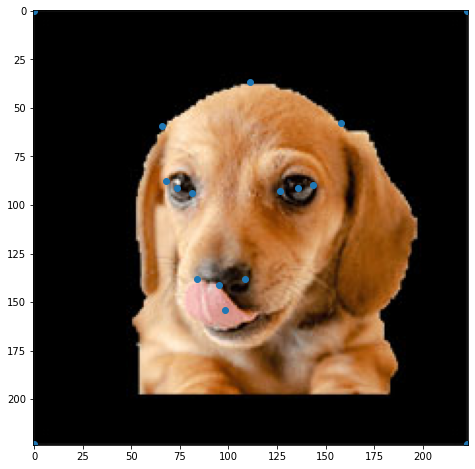

In [83]:
my_dog_points = [
    
    [75, 89],
    [155, 89],
    [103, 153],
    [65, 48],
    [123, 19],
    [183, 46],
    [68, 84],
    [85, 92],
    [143, 91],
    [165, 87],
    [88, 149],
    [120, 149],
    [107, 169]]
my_dog_points = (np.array(my_dog_points).T)*0.78 + np.array([[15],[22]])
my_dog_points = add_corners_2(my_dog_points)
plt.figure(figsize = (8,8))
plt.imshow(not_my_dog)
plt.scatter(*my_dog_points)

## Estimating the camera viewpoint of my doggorino

In [84]:
not_my_dog = greyify(not_my_dog)

In [13]:
with open('sfm_warp_data/3d_points.pickle', 'rb') as handle:
    points_meanaligned_3d = pickle.load(handle)

In [125]:
average_beagle_3d = points_meanaligned_3d['016.beagle']

In [126]:
optimum = scipy.optimize.least_squares(angle_estimation_loss,
                                       np.array([0,0,0,1, 0, 0]),
                                       bounds=([-1.57, -1.57, -1.57, 0.25, -224, -224], [1.57, 1.57, 1.57, 4, 224, 224]),
                                       ftol = None,
                                       args=[average_beagle_3d, my_dog_points[:,:13]])

In [127]:
x = optimum.x

In [128]:
M, T = reconstruct_tmx(x)
        
alpha, beta, gamma, scale, tx, ty = x

In [129]:
x

array([-6.49620924e-03, -1.36201065e-01,  1.41505096e-02,  1.14025654e+00,
       -1.55944625e+01, -2.51492845e+01])

(now i run this in THE CAMERA_ANGLES THING TO GET THE MEAN BEAGLE HAHAHAHAHA)

In [131]:
avg_beag_my_angle = greyify(skio.imread('avg_my_angle.jpg').astype(float)/255)
bc_my_angle = greyify(skio.imread('bc_my_angle.jpg').astype(float)/255)

In [130]:
mean_beag_points = np.array([[ 78.73665787, 134.63729151,  98.66707506,  70.81725375,
        111.60926102, 152.98989858,  70.99484282,  85.07996313,
        126.09116511, 142.17648083,  90.71008668, 105.64147476,
        100.73995678,   0.        ,   0.62899542, 222.36575011,
        223.        ],
       [100.594362  , 100.19219665, 145.2502091 ,  71.57652739,
         58.70429753,  70.97095535, 100.40835814, 103.18011896,
        102.94003263,  99.59805485, 145.14830304, 144.79483461,
        160.36233135,   0.        , 223.        ,   0.        ,
        223.        ]])

mean_malamute_points = np.array([[ 81.6017585 , 137.41219894, 105.54261924,  68.98820619,
        110.58177799, 153.43747501,  72.54974871,  87.96017914,
        128.90507542, 144.85226869,  95.92213173, 112.88097755,
        106.81419417,   0.        ,   0.62899542, 222.36575011,
        223.        ],
       [100.94662359, 100.52013288, 148.58361508,  52.93291958,
         45.10697333,  52.34763007,  99.68566094, 103.41281579,
        103.27140389,  99.07237396, 148.42166929, 148.29525272,
        164.89178216,   0.        , 223.        ,   0.        ,
        223.        ]])

In [132]:
my_features_points = my_dog_points - mean_beag_points

In [133]:
my_features_points

array([[ -5.23665787,   1.26270849,  -3.32707506,  -5.11725375,
         -0.66926102,   4.75010142,  -2.95484282,  -3.77996313,
          0.44883489,   1.52351917,  -7.07008668,   2.95852524,
         -2.27995678,   0.        ,  -0.62899542,   0.63424989,
          0.        ],
       [ -9.174362  ,  -8.77219665,  -3.9102091 , -12.13652739,
        -21.88429753, -13.09095535, -12.88835814,  -9.42011896,
         -9.96003263,  -9.73805485,  -6.92830304,  -6.57483461,
         -6.54233135,   0.        ,   0.        ,   0.        ,
          0.        ]])

In [134]:
me_morphed_to_beag = morph(not_my_dog, not_my_dog, my_dog_points.T, mean_beag_points.T, simplices, 0,1)

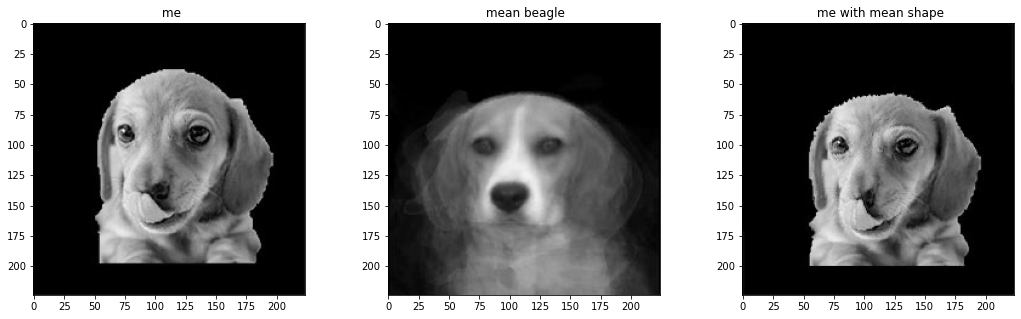

In [135]:
display_dictionary_of_images({'me': not_my_dog, 'mean beagle': avg_beag_my_angle, 'me with mean shape': me_morphed_to_beag}, horiz = True)

In [144]:
me_features_pixels = me_morphed_to_beag - avg_beag_my_angle

In [145]:
me_features_pixels_adjusted = morph(me_features_pixels, me_features_pixels, mean_beag_points.T, mean_malamute_points.T, simplices, 0,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


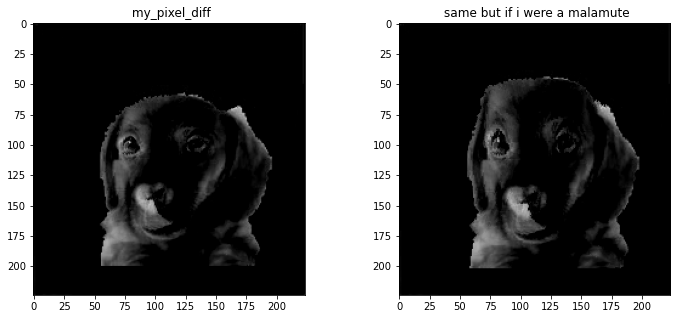

In [153]:
display_dictionary_of_images({'my_pixel_diff': me_features_pixels, 'same but if i were a malamute': me_features_pixels_adjusted}, horiz = True)

In [147]:
malamute_with_my_pixels = (bc_my_angle + me_features_pixels_adjusted)

In [148]:
malamute_with_my_pixels = malamute_with_my_pixels + np.min(malamute_with_my_pixels)
malamute_with_my_pixels = malamute_with_my_pixels/np.max(malamute_with_my_pixels)

In [149]:
malamute_with_my_pixels_and_shape = morph(
    malamute_with_my_pixels,
    malamute_with_my_pixels,
    mean_malamute_points.T,
    (mean_malamute_points + my_features_points).T,
    simplices,
    0, 1)

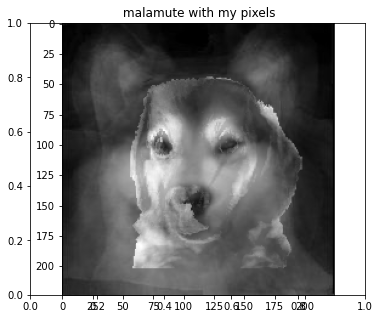

In [150]:
display_dictionary_of_images({'malamute with my pixels': malamute_with_my_pixels})

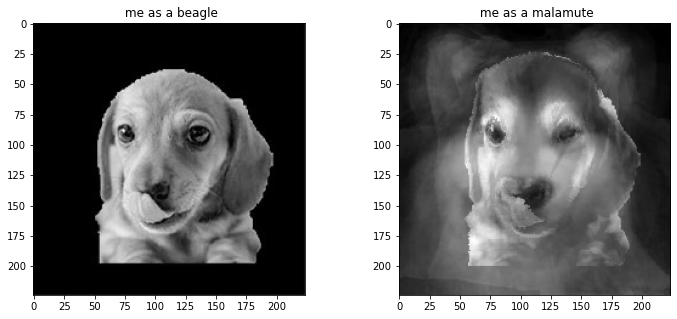

In [151]:
display_dictionary_of_images({'me as a beagle': not_my_dog, 'me as a malamute': malamute_with_my_pixels_and_shape}, horiz = True)